Clearly define a problem or an idea of your choice, where you would need to leverage the Foursquare location data to solve or execute. Remember that data science problems always target an audience and are meant to help a group of stakeholders solve a problem, so make sure that you explicitly describe your audience and why they would care about your problem.

<h2 align="center">Business Opportunity</h2> 
Marijuana is now legal in Canada, opening up business opportunities!

<h3 align="center">Business Question</h3> 
If one wanted to open a marijuana shop in Toronto, where should this shop be located?

<h3 align="center">Research</h3> 
Review of research on marijuana dispensaries finds that marijuana dispensaries are most constrained by zoning regulations and neighborhood opposition.  Marijuana shops are often located near strip clubs, liquour stores, bars, and other adult diversions, possibly due to favorable zoning regulations and tolerant neighbors.     

Although the patrons are normally higher income, these facilities are located in low income areas, often near the outskirts of the city limits, and usually near a freeway offramp.  Perhaps people don't want to live next door to a pot shop, but don't mind driving to a seedier neighborhood to purchase their recreational drugs.  

<h3 align="center">References</h3>

Dineen, J.K., "Cannabis dispensary rules in SF create clusters", San Francisco Chronicle, 10 August 2017, https://www.sfchronicle.com/bayarea/article/Cannabis-dispensary-rules-in-SF-create-clusters-11746532.php

McVey, E., "Recreational marijuana stores are clustered in low-income areas of Denver, Seattle", Marijuana Business Daily, 31 July 2017, https://mjbizdaily.com/chart-recreational-marijuana-stores-clustered-low-income-areas-denver-seattle/

Snell, R. and Beneditti, "Detroit medical marijuana shops sprout like weeds near the suburbs", Crains Detroit Business, 24 April 2016, https://www.crainsdetroit.com/article/20160424/NEWS/160429925/detroit-medical-marijuana-shops-sprout-like-weeds-near-the-suburbs

Thomas,C. and Freisthler, D., "Examining the Locations of Medical Marijuana Dispensaries in Los Angeles"
Drug Alcohol Rev. 2016 May; 35(3): 334–337, Published online 2015 Sep 30. doi: 10.1111/dar.12325, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4814366/

<h3 align="center">Data</h3> 

Data was obtained via the Foursquare API and included location data for adult diversions (including alcohol venues, adult boutiques, hookah bars and strip clubs). To ensure obtained data was not affected by selection bias, data for strip clubs and marijuana dispensaries was also collected via Google Maps. Census data and housing prices were used to extrapolate household income.  

<h3 align="center">Processes completed in this notebook include:</h3> 

    1.  Download data via Internet page scrape,
    2.  Using the data from the page scrape, create pandas dataframe,
    3.  Clean data in pandas dataframe (remove/rename empty cells),
    4.  Explore and cluster neighborhoods,
    5.  Geocode using postal codes,
    6.  GeoMap neighborhoods,
    7.  Assign FourSquare feature data to neighborhoods,
    8.  Cluster neighborhoods based on FourSquare-assigned features,
    9.  Group, One-Hot Encode and Analyze Neighborhood Clusters,
    10. Visualize Feature-Grouped Clusters.

<H4><center>Set Up Environment</H4>

In [1]:
# library imports
import pandas as pd
pd.set_option('display.max_columns', None)    
pd.set_option('display.max_rows', None)
import numpy as np
from pandas.io.json import json_normalize # JSON file -> pandas DF
import json # JSON file manipulation
from geopy.geocoders import Nominatim     # converts address into latitude and longitude values
import requests # HTTP library
from bs4 import BeautifulSoup # scrapes info from web pages, on top of HTML or XLM parser
import matplotlib.pyplot as plt # plotting library
import matplotlib.cm as cm
import matplotlib.colors as colors
# %matplotlib inline # magic that allows matplot in Jupyter
# !conda update -n base -c defaults conda --yes     # may needto run first time in new environment
# !conda install -c conda-forge folium=0.5.0 --yes  # may need to run first time in new environment
import folium                                       # map rendering
from sklearn.cluster import KMeans                  # clustering algorithm

/home/lin/anaconda3/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [12]:
# Setup Foursquare credentials

# CLIENT_ID = 'Your Client ID'
# CLIENT_SECRET = 'Your Client Secret'
# VERSION = '20181102'

# print('Your credentails:')
# print('CLIENT_ID: ' + CLIENT_ID)
# print('CLIENT_SECRET:' + CLIENT_SECRET)

In [13]:
# Determine geographic coordinates for Toronto
address = 'Toronto'
geolocator = Nominatim(user_agent="toro_locator")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


<H4><center>Acquire Data</H4>
Download census data, GoogleMaps data, and Canadian post code data scraped (using Beautiful Soup) from wikipedia (url ="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")  


In [2]:
#Toronto Postal Code and Neighborhood Data
toro = pd.read_csv("~/Data/torontoZipsNeighborhoods.csv")
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = requests.get(url).text  # wikiArticle -> text document
wikiHtml = BeautifulSoup(page, "html.parser")  # text -> parseTree
neighborhoodTable = wikiHtml.find("table", class_ = "wikitable")  # exracting info from html data
neighborhoodRows = neighborhoodTable.find_all("tr")  # exracting info from html data

In [3]:
# Toronto population data 
toro_census = pd.read_csv('~/Data/toronto_census.csv') # load the census data
toro_census.dropna()

PostalCode           Borough  Neighbourhood Number  Population, 2016  \
0         M1B       Scarborough                 263.0           90290.0   
1         M1C       Scarborough                 134.0           12494.0   
2         M1E       Scarborough                 411.0           54764.0   
3         M1G       Scarborough                 137.0           53485.0   
4         M1H       Scarborough                 127.0           29960.0   
5         M1J       Scarborough                 139.0           16724.0   
6         M1K       Scarborough                 125.0           13641.0   
7         M1L       Scarborough                 302.0           56512.0   
8         M1M       Scarborough                 385.0           55834.0   
9         M1N       Scarborough                 122.0           22291.0   
10        M1P       Scarborough                 256.0           51575.0   
11        M1R       Scarborough                 119.0           27917.0   
12        M1S       Scarborough                 128.0           23757.0   
13        M1T       Scarborough                 118.0           27446.0   
14        M1V       Scarborough                 379.0           86468.0   
15        M1W       Scarborough                 116.0           24623.0   
16        M1X       Scarborough                  25.0           30491.0   
17        M2H        North York                  48.0           16934.0   
18        M2J        North York                 100.0           42774.0   
19        M2K        North York                  52.0           21396.0   
20        M2L        North York                  81.0           27078.0   
21        M2M        North York                 137.0           90362.0   
22        M2N        North York                  37.0           16936.0   
23        M2R        North York                  35.0           26274.0   
24        M3A        North York                  45.0           34805.0   
25        M3B        North York                  42.0           27695.0   
26        M3C        North York                  44.0           21933.0   
27        M3H        North York                  93.0           67397.0   
28        M3J        North York                  27.0           27593.0   
29        M3K        North York                  38.0           16164.0   
30        M3M        North York                 110.0           11058.0   
31        M4A        North York                  43.0           17510.0   
32        M4B         East York                 118.0           31216.0   
33        M4C         East York                  60.0            7865.0   
34        M4E      East Toronto                  63.0           21567.0   
35        M4G         East York                  56.0           16828.0   
36        M4H         East York                  55.0           21108.0   
37        M4J         East York                  57.0           11499.0   
38        M4K      East Toronto                 200.0           61173.0   
39        M4L      East Toronto                  54.0           18675.0   
40        M4N   Central Toronto                 208.0           29786.0   
41        M4P   Central Toronto                 203.0           46433.0   
42        M4S   Central Toronto                 100.0           11817.0   
43        M4T   Central Toronto                  98.0           20923.0   
44        M4V   Central Toronto                  97.0           12528.0   
45        M4V   Central Toronto                  96.0           10968.0   
46        M4X  Downtown Toronto                 145.0           30284.0   
47        M5A  Downtown Toronto                 149.0           76716.0   
48        M5B  Downtown Toronto                 107.0           21210.0   
49        M5C  Downtown Toronto                  46.0           15818.0   
50        M5G  Downtown Toronto                  76.0           25797.0   
51        M5H  Downtown Toronto                  69.0            7727.0   
52        M5J  Downtown Toro

In [69]:
# Data obtained from googleMaps for marijuana outlets and strip clubs in Toronto
toro_marijuana = pd.read_csv('~/Data/potShopsViaGoogleMaps.csv', delimiter=',', names = ["Name", "Latitude", "Longitude"])
toro_stripClubs = pd.read_csv('~/Data/toroStripClubs.csv', delimiter=',', names = ["Name", "Latitude", "Longitude"])
toro_pot = pd.read_csv('~/Data/potShopNeighbors.csv', names=['PostalCode','Neighborhood','Name','Latitude', 'Longitude'])

<H4> Visually Examine Neighborhood Characteristics </H4>

Visually reviewing neighborhood maps might provide guidance in locating the next dispensary.  The human eye is capable of quickly detecting patterns, and folium maps provide an easy way to display this data.

<H4><center>Question:  Is there a relationship between spending power and local marijuana dispensaries?</H4>

In [5]:
# Create a dataframe with relevant fields from census data
PostCode = []
Borough=[]
Neighborhood=[]
Population=[]
Longitude = []
Latitude = []
P_density = []
Area = []
SP = []

In [6]:
# populate dataframe with census data
for i in toro['PostalCode']:
    if toro_census['PostalCode'].isin([i]).any():
        PostCode.append(i)
        loc = toro.index[toro['PostalCode']==i]
        Borough.append(toro['Borough'][loc].values[0])
        Neighborhood.append(toro['Neighborhood'][loc].values[0])
        Latitude.append(toro['Latitude'][loc].values[0])
        Longitude.append(toro['Longitude'][loc].values[0])
        loc = toro_census.index[toro_census['PostalCode']==i]
        Population.append(toro_census['Population, 2016'][loc].values[0])
        P_density.append(toro_census['Population density per square kilometre'][loc].values[0])
        Area.append(toro_census['Land area in square kilometres'][loc].values[0])
        sp =   2 * toro_census['  Under $5,000'][loc].values[0] + 3 * toro_census['  $5,000 to $9,999'][loc].values[0] \
            +  5 * toro_census['  $10,000 to $14,999'][loc].values[0] + 7 * toro_census['  $15,000 to $19,999'][loc].values[0] \
            +  9 * toro_census['  $20,000 to $24,999'][loc].values[0] + 11 * toro_census['  $25,000 to $29,999'][loc].values[0] \
            + 13 * toro_census['  $30,000 to $34,999'][loc].values[0] + 15 * toro_census['  $35,000 to $39,999'][loc].values[0] \
            + 17 * toro_census['  $40,000 to $44,999'][loc].values[0] + 19 * toro_census['  $45,000 to $49,999'][loc].values[0] \
            + 22 * toro_census['  $50,000 to $59,999'][loc].values[0] + 26 * toro_census['  $60,000 to $69,999'][loc].values[0] \
            + 30 * toro_census['  $70,000 to $79,999'][loc].values[0] + 34 * toro_census['  $80,000 to $89,999'][loc].values[0] \
            + 38 * toro_census['  $90,000 to $99,999'][loc].values[0] + 45 * toro_census['    $100,000 to $124,999'][loc].values[0] \
            + 55 * toro_census['    $125,000 to $149,999'][loc].values[0] + 70 * toro_census['    $150,000 to $199,999'][loc].values[0] \
            + 90 * toro_census['    $200,000 and over'][loc].values[0]
        SP.append(sp)
toro_data = pd.DataFrame({'PostCode':PostCode, 'Neighborhood':Neighborhood,'Latitude':Latitude,
                        'Longitude':Longitude,'Population':Population,'Area':Area,'SpendingPower':SP})
# normalize Spending Power
toro_data["SpendingPower"] = (toro_data["SpendingPower"] - toro_data["SpendingPower"].mean())/toro_data["SpendingPower"].std()

In [9]:
# Create a heatmap of spending power in Toronto neighborhoods from census data

from folium import plugins
from folium.plugins import HeatMap

max_amount = float(toro_data['SpendingPower'].max())

toro_hmap = folium.Map(location=[latitude, longitude], zoom_start=11) 

hm_wide = HeatMap( list(zip(toro_data.Latitude.values, toro_data.Longitude.values, toro_data.SpendingPower.values)),
        min_opacity=0.5,
        max_zoom=18, 
        max_val= max_amount, 
        radius=18,
        blur=15,
        gradient=None,
        overlay=True).add_to(toro_hmap)

toro_hmap.save('toroSpendingPower.html')
toro_hmap

In [10]:
# Add datapoints for existing marijuana dispensaries

for i in range(0, len(toro_marijuana)-1):
# for row in toro_marijuana:
    folium.CircleMarker(
        [toro_marijuana.iloc[i]['Latitude'], toro_marijuana.iloc[i]['Longitude']],
            #[lat, lon],
        radius=2,
        popup='PotShop',
        color='green',
        fill=True,
        fill_color='light green',
        fill_opacity=0.5).add_to(toro_hmap)
toro_hmap.save('toroSpendPotShops.html')
toro_hmap

Nice map; however, it doesn't show an exploitable relationship between the average neighborhood resident spending power and marijuana dispensaries.

<H4><center>Question: Is there a relationship between neighborhood size and marijuana dispensaries</H4>

In [33]:
#Not all neighborhoods are the same geographic size

toroHoodMap = folium.Map(location=[latitude, longitude], zoom_start=11) 

for Latitude, Longitude, Area, Neighhborhood in zip(toro_data['Latitude'], toro_data['Longitude'], toro_data['Area'], toro_data['Neighborhood']):
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=8*np.sqrt(Area),
        color='blue',
        fill=True,
        fill_color='lightgreen',
        fill_opacity=0.7,
        parse_html=False).add_to(toroHoodMap)

toroHoodMap.save('toroNeighborhoodSize.html')
toroHoodMap

In [37]:
# Add the locations of existing marijuana dispensaries (in red) to visually inspect for relationship 

for i in range(0, len(toro_marijuana)-1):
# for row in toro_marijuana:
    folium.CircleMarker(
        [toro_marijuana.iloc[i]['Latitude'], toro_marijuana.iloc[i]['Longitude']],
            #[lat, lon],
        radius=4,
        popup='PotShop',
        color='red',
        fill=True,
        fill_color='pink',
        fill_opacity=0.5).add_to(toroHoodMap)
toroHoodMap.save('toroDispensariesHoodSize.html')
toroHoodMap

Although the map is pretty, it doesn't help much in identifying possible dispensary locations.  Current dispensaries are generally in smaller (physical area) neighborhoods, but not all (physical area) small neighborhoods have marijuana dispensaries.

<H4><center> Is there a relationship between neighborhood density and marijuana dispensary locations?</H4>

In [67]:
#Not all neighborhoods are the same density

toroDensityMap = folium.Map(location=[latitude, longitude], zoom_start=11) 

colors = ['lightblue','lightgreen','yellow','orange','red']  # blue as least dense; red as most dense

# temporarily add in a DensityCategory field for plotting, bin the neighborhood densities, and plot
toro_data['Density']= toro_data.Population/toro_data.Area
bins = [0, 3700, 4500, 6000, 7500, np.inf]
names = [0,1,2,3,4]
toro_data['DensityCategory'] = pd.cut(toro_data['Density'], bins, labels=names)

for Latitude, Longitude, Area, DensityCategory in zip(
    toro_data['Latitude'], toro_data['Longitude'], toro_data['Area'], toro_data['DensityCategory']):
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=8*np.sqrt(Area),
        color=None,
        fill=True,
        fill_color=colors[DensityCategory],
        fill_opacity=0.7,
        parse_html=False).add_to(toroDensityMap)

#remove the temporary DensityCategory field
toro_data.drop(['DensityCategory'], axis=1, inplace=True)

toroDensityMap.save('toroNeighborhoodDensity.html')
toroDensityMap

In [68]:
# Add the locations of existing marijuana dispensaries (in black) to visually examine for relationship

for i in range(0, len(toro_marijuana)-1):
# for row in toro_marijuana:
    folium.CircleMarker(
        [toro_marijuana.iloc[i]['Latitude'], toro_marijuana.iloc[i]['Longitude']],
            #[lat, lon],
        radius=4,
        popup='PotShop',
        color='black',
        fill=True,
        fill_color='grey',
        fill_opacity=0.5).add_to(toroDensityMap)
toroDensityMap.save('toroDispensariesDensity.html')
toroDensityMap

The map with the neighborhood sizes augmented by color-coded population density (blue-green-yellow-orange-red in order of increasing density).  One can see that marijuana dispensaries are generally located in population-dense areas; however, this visual provides no definitive insights as to why marijuana dispensaries are located in an area.

<H4><center>Does the location of strip clubs provide insight as to the location of marijuana dispensaries?</H4>

<H4><center>Nearby Venues</H4>
Research (cited above) discusses marijuana dispensaries located in the vicinity of strip clubs.  Locations of marijuana dispensaries and strip clubs obtained from GoogleMaps data.  Possibly due to self-report bias (people might not want to share when visiting strip club) or selection bias (the people who use Foursquare regularly may not frequent these venues), Foursquare data for strip clubs and marijuana dispensaries in Toronto does not accurately reflect the number of these venues.

In [73]:
# Plot locations of Strip Clubs (shown as red/pink markers) in Toronto
toroStripClubMap = folium.Map(location=[latitude, longitude], zoom_start=11) 

for i in range(0, len(toro_stripClubs)-1):
# for row in toro_stripClubs:
    folium.CircleMarker(
        [toro_stripClubs.iloc[i]['Latitude'], toro_stripClubs.iloc[i]['Longitude']],
        radius=6,
        popup='PotShop',
        color='red',
        fill=True,
        fill_color='pink',
        fill_opacity=0.8).add_to(toroStripClubMap)
toroStripClubMap.save('toroStripClubs.html')
toroStripClubMap

In [75]:
# Add the locations of existing marijuana dispensaries (in green) to visually examine for relationship

for i in range(0, len(toro_marijuana)-1):
# for row in toro_marijuana:
    folium.CircleMarker(
        [toro_marijuana.iloc[i]['Latitude'], toro_marijuana.iloc[i]['Longitude']],
            #[lat, lon],
        radius=4,
        popup='PotShop',
        color='green',
        fill=True,
        fill_color='lightgreen',
        fill_opacity=0.5).add_to(toroStripClubMap)
toroStripClubMap.save('toroStripClubDispensaries.html')
toroStripClubMap

Visual inspection shows a tendency towards co-location of strip clubs and marijuana dispensaries.

<H4><center>Can Foursquare provide neighborhood information suggestion a location for a marijuana dispensary?</H4>

<H4><center>Can we use Foursquare help determine if a relationship exists?</H4></center><P>
Foursquare does not accurately report all strip clubs and marijuana dispensaries in Toronto, possibly due to self-report bias (individuals concerned re legal liability and relationship preservation might not report visits to these venues) and selection bias (Foursquare usage is not consistent throught the population).  To counteract these biases, information on strip clubs and marijuana dispensaries was collected via GoogleMaps.<P>Foursquare can help by clustering neighborhood venues for check-ins.

In [79]:
# First define a function to use Foursquare to look up locations within 1000 meters (0.62 miles for those metric-impaired) of a given latitude/longitude.  

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [82]:
# Use Foursquare to return general Toronto locales
### DO NOT RUN THIS AGAIN -- USE THE PICKLE
LIMIT = 200  
venues1K = getNearbyVenues(names=toro_data['Neighborhood'],
                                   latitudes=toro_data['Latitude'],
                                   longitudes=toro_data['Longitude']
                          )
venues1K.to_pickle('~/Data/venues1K.pkl')  # storing data in a pickle means you don't have to run foursquare again #

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West, Steeles West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview Central
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, Riverdale
The Beaches West, India Baz

In [83]:
# Use Foursquare to return general Toronto locales
### DO NOT RUN THIS AGAIN -- USE THE PICKLE
LIMIT = 200
potVenues1K = getNearbyVenues(names=toro_pot['Neighborhood'],
                                   latitudes=toro_pot['Latitude'],
                                   longitudes=toro_pot['Longitude']
                                  )
#potVenues1K.to_pickle('~/Data/potVenues1K.pkl')  # storing data in a pickle means you don't have to run foursquare again #

Scarborough Village
Dorset Park, Scarborough Town Centre, Wexford ...
Newtonbrook, Willowdale
Newtonbrook, Willowdale
Don Mills North
Northwood Park, York University, North York
East Toronto
East Toronto
Davisville North
Moore Park, Summerhill East
Moore Park, Summerhill East
Moore Park, Summerhill East
Ryerson, Garden District
Ryerson, Garden District
Adelaide, King, Richmond
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbo...
CN Tower, Bathurst Quay, Island airport, Harbo...
Caledonia-Fairbanks
Caledonia-Fairbanks
Dovercourt Village, Dufferin
The Junction North, Runnymede
Humber Bay Shores, Mimico South, New Toronto
Humber Bay Shores, Mimico South, New Toronto
Humber Bay, King's Mill Park, Kingsway Park So...
Humber Bay, King's Mill Park, Kingsway Park So...


In [89]:
print("TORONTO NEIGHBORHOODS:\n", venues1K.groupby('Neighborhood').count(), 
      "\n\nTORONTO NEIGHBORHOODS NEAR MARIJUANA DISPENSARIES:\n", potVenues1K.groupby('Neighborhood').count())

TORONTO NEIGHBORHOODS:
                                                     Neighborhood Latitude  \
Neighborhood                                                                
Adelaide, King, Richmond                                              100   
Agincourt                                                              49   
Agincourt North, L'Amoreaux East, Milliken, Ste...                     28   
Albion Gardens, Beaumond Heights, Humbergate, J...                     16   
Alderwood, Long Branch                                                 24   
Bathurst Manor, Downsview North, Wilson Heights                        27   
Bayview Village                                                        12   
Bedford Park, Lawrence Manor East                                      41   
Birch Cliff, Cliffside West                                            14   
Bloordale Gardens, Eringate, Markland Wood, Old...                     15   
Brockton, Exhibition Place, Parkdale Village        

In [91]:
print('In Toronto, there are', len(venues1K['Venue Category'].unique()), "unique venue categories;\nand", \
      len(potVenues1K['Venue Category'].unique()), "unique venue categories near marijuana dispensaries")

In Toronto, there are 318 unique venue categories;
and 221 unique venue categories near marijuana dispensaries


<H4>One Hot Encode the Unique Categories </H4>

In [95]:
# one hot encoding
venues1K_onehot = pd.get_dummies(venues1K[['Venue Category']], prefix="", prefix_sep="")
potVenues1K_onehot = pd.get_dummies(potVenues1K[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues1K_onehot['Neighborhood'] = venues1K['Neighborhood'] 
potVenues1K_onehot['Neighborhood'] = potVenues1K['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns1K = [venues1K_onehot.columns[-1]] + list(venues1K_onehot.columns[:-1])
venues1K_onehot = venues1K_onehot[fixed_columns1K]
fixed_columnsP1K = [potVenues1K_onehot.columns[-1]] + list(potVenues1K_onehot.columns[:-1])
potVenues1K_onehot = potVenues1K_onehot[fixed_columnsP1K]

print("TORONTO VENUES\n", venues1K_onehot.head(2), "\n\n\nTORONTO VENUES near marijuana dispensaries", potVenues1K_onehot.head(2))

TORONTO VENUES
    Zoo  Accessories Store  Afghan Restaurant  Airport  Airport Lounge  \
0    0                  0                  0        0               0   
1    0                  0                  0        0               0   

   American Restaurant  Amphitheater  Animal Shelter  Antique Shop  Aquarium  \
0                    0             0               0             0         0   
1                    0             0               0             0         0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0            0           0                    0                 0   
1            0           0                    0                 0   

   Athletics & Sports  Auto Dealership  Auto Garage  Auto Workshop  \
0                   0                0            0              0   
1                   0                0            0              0   

   Automotive Shop  BBQ Joint  Baby Store  Badminton Court  Bagel Shop  \
0                0          0 

In [99]:
venues1K_grouped = venues1K_onehot.groupby('Neighborhood').sum().reset_index()
potVenues1K_grouped = potVenues1K_onehot.groupby('Neighborhood').sum().reset_index()

print("TORONTO, Quantity of Nearby Venues", (venues1K_grouped.sum()).head(), 
      "\n\nVenues Near Marijuana Dispensaries", (potVenues1K_grouped.sum()).head() )
      

TORONTO, Number Nearby by Venue Neighborhood         Adelaide, King, RichmondAgincourtAgincourt Nor...
Zoo                                                                  1
Accessories Store                                                    3
Afghan Restaurant                                                    2
Airport                                                              2
dtype: object 

Venues Near Marijuana Dispensaries Neighborhood          Adelaide, King, RichmondCN Tower, Bathurst Qua...
Yoga Studio                                                          11
Adult Boutique                                                        1
Afghan Restaurant                                                     2
African Restaurant                                                    1
dtype: object


In [100]:
num_top_venues = 10

def getTopVenues(venues_grouped):
    for hood in venues_grouped['Neighborhood']:
        print("----"+hood+"----")
        temp = venues_grouped[venues_grouped['Neighborhood'] == hood].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[1:]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq': 2})
        print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
        print('\n')

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [103]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues1K_sorted = pd.DataFrame(columns=columns)
venues1K_sorted['Neighborhood'] = venues1K_grouped['Neighborhood']
potVenues1K_sorted = pd.DataFrame(columns=columns)
potVenues1K_sorted['Neighborhood'] = potVenues1K_grouped['Neighborhood']

for ind in np.arange(venues1K_sorted.shape[0]):
    venues1K_sorted.iloc[ind, 1:] = return_most_common_venues(venues1K_grouped.iloc[ind, :], num_top_venues)
for ind in np.arange(potVenues1K_sorted.shape[0]):
    potVenues1K_sorted.iloc[ind, 1:] = return_most_common_venues(potVenues1K_grouped.iloc[ind, :], num_top_venues)

print("TORONTO VENUES\n", venues1K_sorted.head(), "\n\nVenues near Marijuana Dispensaries\n", potVenues1K_sorted.head())

TORONTO VENUES
                                         Neighborhood 1st Most Common Venue  \
0                           Adelaide, King, Richmond                  Café   
1                                          Agincourt    Chinese Restaurant   
2  Agincourt North, L'Amoreaux East, Milliken, St...    Chinese Restaurant   
3  Albion Gardens, Beaumond Heights, Humbergate, ...           Pizza Place   
4                             Alderwood, Long Branch        Discount Store   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Coffee Shop                 Hotel               Theater   
1         Shopping Mall           Coffee Shop                Bakery   
2           Pizza Place              Pharmacy                Bakery   
3         Grocery Store              Pharmacy      Sushi Restaurant   
4           Pizza Place              Pharmacy         Grocery Store   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0   American Rest

In [283]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues1K_grouped['Neighborhood']
for ind in np.arange(venues1K_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues1K_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                           Adelaide, King, Richmond                  Café   
1                                          Agincourt    Chinese Restaurant   
2  Agincourt North, L'Amoreaux East, Milliken, St...    Chinese Restaurant   
3  Albion Gardens, Beaumond Heights, Humbergate, ...           Pizza Place   
4                             Alderwood, Long Branch        Discount Store   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Coffee Shop                 Hotel               Theater   
1         Shopping Mall           Coffee Shop                Bakery   
2           Pizza Place              Pharmacy                Bakery   
3         Grocery Store              Pharmacy      Sushi Restaurant   
4           Pizza Place              Pharmacy         Grocery Store   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0   American Restaurant   Japanese Restaurant          Concert Hall   
1            Restaurant        Sandwich Place           Supermarket   
2             BBQ Joint                  Park          Dessert Shop   
3  Fast Food Restaurant                  Park            Beer Store   
4         Garden Center        Sandwich Place            Donut Shop   

  8th Most Common Venue  9th Most Common Venue 10th Most Common Venue  
0         Movie Theater        Thai Restaurant                 Bakery  
1  Caribbean Restaurant  Vietnamese Restaurant        Badminton Court  
2           Event Space       Malay Restaurant          Shopping Mall  
3   Fried Chicken Joint         Hardware Store            Coffee Shop  
4          Liquor Store            Gas Station          Shopping Mall

In [104]:
print(getTopVenues(venues1K_grouped), getTopVenues(potVenues1K_grouped))

----Adelaide, King, Richmond----
                           venue  freq
0                           Café   6.0
1                          Hotel   5.0
2                    Coffee Shop   5.0
3                        Theater   4.0
4            Japanese Restaurant   3.0
5            American Restaurant   3.0
6                   Concert Hall   3.0
7  Vegetarian / Vegan Restaurant   2.0
8                     Restaurant   2.0
9                    Pizza Place   2.0


----Agincourt----
                  venue  freq
0    Chinese Restaurant   5.0
1         Shopping Mall   4.0
2  Caribbean Restaurant   2.0
3           Supermarket   2.0
4                Bakery   2.0
5            Restaurant   2.0
6        Sandwich Place   2.0
7           Coffee Shop   2.0
8      Sushi Restaurant   1.0
9        Breakfast Spot   1.0


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                  venue  freq
0    Chinese Restaurant   5.0
1                Bakery   2.0
2              Pharmacy   2.0
3

                       venue  freq
0                Pizza Place   3.0
1       Fast Food Restaurant   2.0
2                      Beach   2.0
3                 Sports Bar   1.0
4                Wings Joint   1.0
5               Burger Joint   1.0
6  Cajun / Creole Restaurant   1.0
7                       Park   1.0
8     Furniture / Home Store   1.0
9                     Office   0.0


----Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park----
                 venue  freq
0                 Park   3.0
1                Hotel   2.0
2                 Bank   2.0
3          Pizza Place   2.0
4             Pharmacy   1.0
5  American Restaurant   1.0
6    Convenience Store   1.0
7   Mexican Restaurant   1.0
8              Theater   1.0
9    Fish & Chips Shop   1.0


----Davisville----
                  venue  freq
0           Coffee Shop   7.0
1    Italian Restaurant   6.0
2      Sushi Restaurant   6.0
3                  Café   4.0
4     Indian Restaurant   4.0
5           Pi

                  venue  freq
0           Coffee Shop   2.0
1              Pharmacy   2.0
2                  Park   2.0
3                Bakery   1.0
4         Grocery Store   1.0
5        Sandwich Place   1.0
6  Fast Food Restaurant   1.0
7     Korean Restaurant   1.0
8         Shopping Mall   1.0
9                 Diner   1.0


----Humber Bay Shores, Mimico South, New Toronto----
                  venue  freq
0                  Park   2.0
1                Bakery   1.0
2          Dessert Shop   1.0
3          Liquor Store   1.0
4          Skating Rink   1.0
5         Grocery Store   1.0
6                  Café   1.0
7        Sandwich Place   1.0
8    Mexican Restaurant   1.0
9  Fast Food Restaurant   1.0


----Humber Bay, King's Mill Park, Kingsway Park South East, Mimico NE, Old Mill South, The Queensway East, Royal York South East, Sunnylea----
                         venue  freq
0           Italian Restaurant   2.0
1                         Park   2.0
2                Shopping Mal

                       venue  freq
0                Coffee Shop   8.0
1             Clothing Store   5.0
2                       Café   4.0
3                 Restaurant   4.0
4            Bubble Tea Shop   3.0
5           Ramen Restaurant   3.0
6                   Tea Room   3.0
7                      Diner   3.0
8  Middle Eastern Restaurant   3.0
9                  Gastropub   3.0


----Scarborough Village----
                     venue  freq
0     Fast Food Restaurant   3.0
1        Convenience Store   2.0
2      Japanese Restaurant   1.0
3            Bowling Alley   1.0
4               Restaurant   1.0
5              Pizza Place   1.0
6              Coffee Shop   1.0
7           Sandwich Place   1.0
8            Train Station   1.0
9  New American Restaurant   0.0


----Silver Hills, York Mills----
                     venue  freq
0                     Park   3.0
1                     Pool   1.0
2                      Zoo   0.0
3               Nail Salon   0.0
4          Organic Gro

                      venue  freq
0        Italian Restaurant   9.0
1               Coffee Shop   7.0
2                      Café   6.0
3                       Spa   4.0
4                Restaurant   3.0
5  Mediterranean Restaurant   3.0
6         Indian Restaurant   3.0
7          Sushi Restaurant   3.0
8                  Boutique   3.0
9                     Hotel   3.0


----East Toronto----
                  venue  freq
0         Grocery Store   4.0
1           Pizza Place   3.0
2           Coffee Shop   3.0
3        Discount Store   3.0
4  Fast Food Restaurant   2.0
5          Skating Rink   2.0
6     Food & Drink Shop   1.0
7         Shopping Mall   1.0
8            Beer Store   1.0
9            Food Truck   1.0


----Humber Bay Shores, Mimico South, New Toronto----
                venue  freq
0                Park   7.0
1         Coffee Shop   6.0
2            Pharmacy   5.0
3       Grocery Store   5.0
4    Sushi Restaurant   4.0
5  Italian Restaurant   4.0
6                Bank 

In [105]:
adult_venues1K = venues1K_grouped['Bar'] + venues1K_grouped['Beach Bar'] + venues1K_grouped['Beer Bar'] \
    + venues1K_grouped['Beer Store'] + venues1K_grouped['Brewery'] + venues1K_grouped['Cocktail Bar'] \
    + venues1K_grouped['Comedy Club'] + venues1K_grouped['Dive Bar'] + venues1K_grouped['Gaming Cafe'] \
    + venues1K_grouped['Gastropub'] + venues1K_grouped['Hookah Bar'] + venues1K_grouped['Karaoke Bar'] \
    + venues1K_grouped['Lounge'] + venues1K_grouped['Nightclub'] + venues1K_grouped['Pool Hall'] \
    + venues1K_grouped['Pub'] + venues1K_grouped['Rock Club'] + venues1K_grouped['Smoke Shop'] \
    + venues1K_grouped['Speakeasy'] + venues1K_grouped['Sports Bar'] + venues1K_grouped['Whisky Bar'] \
    + venues1K_grouped['Wine Bar']

adult_potVenues1K = potVenues1K_grouped['Adult Boutique'] + potVenues1K_grouped['Bar'] \
    + potVenues1K_grouped['Beer Bar']  + potVenues1K_grouped['Beer Store'] + potVenues1K_grouped['Brewery'] \
    + potVenues1K_grouped['Cocktail Bar']  + potVenues1K_grouped['Comedy Club'] \
    + potVenues1K_grouped['Gaming Cafe'] + potVenues1K_grouped['Hookah Bar'] + potVenues1K_grouped['Jazz Club'] \
    + potVenues1K_grouped['Liquor Store'] + potVenues1K_grouped['Lounge'] + potVenues1K_grouped['Nightclub'] \
    + potVenues1K_grouped['Pool Hall']  + potVenues1K_grouped['Pub'] + potVenues1K_grouped['Smoke Shop'] \
    + potVenues1K_grouped['Speakeasy'] + potVenues1K_grouped['Sports Bar'] + potVenues1K_grouped['Wine Bar'] \
    + potVenues1K_grouped['Karaoke Bar']

In [127]:
print("dataframe sizes are:\nToronto:", venues1K.shape, "\nMarijuana:", potVenues1K.shape)
# print("Total Toronto venues", (venues1K_grouped.sum()), "of which", (adult_venues1K.sum()), "are adult venues")

tot_venues_wi_1K  = venues1K_grouped.drop(['Neighborhood'], axis=1)
tot_venues_wi_pot1K  = venues1K_grouped.drop(['Neighborhood'], axis=1)
# print("venues within 1000 meters", tot_venues_wi_1K)
# print("venues within 1000 meters", tot_venues_wi_1K)

adult_potVenues1K_list = potVenues1K_grouped.columns.values.tolist()
len(adult_potVenues1K_list)

dataframe sizes are:
Toronto: (3951, 7) 
Marijuana: (1525, 7)


221

<H3>Cluster the neighborhoods to view similarities</H3>
A cluster size of 5 is common, so staring by clustering into 5 groups

In [140]:
# set number of clusters
kclusters = 5
venues1K_grouped_clustering = venues1K_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues1K_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

In [151]:
#Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
venues1K_merged = venues1K
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
venues1K_merged = venues1K_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
venues1K_merged.head() # check the last columns!

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Rouge, Malvern              43.806686              -79.194353   
1  Rouge, Malvern              43.806686              -79.194353   
2  Rouge, Malvern              43.806686              -79.194353   
3  Rouge, Malvern              43.806686              -79.194353   
4  Rouge, Malvern              43.806686              -79.194353   

                 Venue  Venue Latitude  Venue Longitude  \
0   Images Salon & Spa       43.802283       -79.198565   
1       Caribbean Wave       43.798558       -79.195777   
2  Staples Morningside       43.800285       -79.196607   
3              Wendy's       43.802008       -79.198080   
4             Harvey's       43.800106       -79.198258   

                  Venue Category  Cluster Labels 1st Most Common Venue  \
0                            Spa               3  Fast Food Restaurant   
1           Caribbean Restaurant               3  Fast Food Restaurant   
2  Paper / Office Supplies Store               3  Fast Food Restaurant   
3           Fast Food Restaurant               3  Fast Food Restaurant   
4           Fast Food Restaurant               3  Fast Food Restaurant   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Coffee Shop        Sandwich Place                   Gym   
1           Coffee Shop        Sandwich Place                   Gym   
2           Coffee Shop        Sandwich Place                   Gym   
3           Coffee Shop        Sandwich Place                   Gym   
4           Coffee Shop        Sandwich Place                   Gym   

  5th Most Common Venue    6th Most Common Venue 7th Most Common Venue  \
0                Bakery  Fruit & Vegetable Store    Chinese Restaurant   
1                Bakery  Fruit & Vegetable Store    Chinese Restaurant   
2                Bakery  Fruit & Vegetable Store    Chinese Restaurant   
3                Bakery  Fruit & Vegetable Store    Chinese Restaurant   
4                Bakery  Fruit & Vegetable Store    Chinese Restaurant   

           8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0  Paper / Office Supplies Store                  Park       Greek Restaurant  
1  Paper / Office Supplies Store                  Park       Greek Restaurant  
2  Paper / Office Supplies Store                  Park       Greek Restaurant  
3  Paper / Office Supplies Store                  Park       Greek Restaurant  
4  Paper / Office Supplies Store                  Park       Greek Restaurant

In [172]:
# put dataframe on a diet -- full DF takes too long to plot

venues1K_inTransition = venues1K_merged.filter(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude','Cluster Labels'], axis=1)
venues1K_forPlotting = venues1K_inTransition.drop_duplicates()
venues1K_forPlotting.head(-5)

Neighborhood  \
0                                        Rouge, Malvern   
17               Highland Creek, Rouge Hill, Port Union   
21                    Guildwood, Morningside, West Hill   
45                                               Woburn   
52                                            Cedarbrae   
84                                  Scarborough Village   
96          East Birchmount Park, Ionview, Kennedy Park   
117                     Clairlea, Golden Mile, Oakridge   
145     Cliffcrest, Cliffside, Scarborough Village West   
158                         Birch Cliff, Cliffside West   
172   Dorset Park, Scarborough Town Centre, Wexford ...   
214                                   Maryvale, Wexford   
241                                           Agincourt   
290             Clarks Corners, Sullivan, Tam O'Shanter   
323   Agincourt North, L'Amoreaux East, Milliken, St...   
351                       L'Amoreaux West, Steeles West   
376                                   Hillcrest Village   
398                        Fairview, Henry Farm, Oriole   
441                                     Bayview Village   
453                            Silver Hills, York Mills   
457                             Newtonbrook, Willowdale   
493                                    Willowdale South   
593                                     Willowdale West   
604                                           Parkwoods   
632                                     Don Mills North   
661                    Flemingdon Park, Don Mills South   
704     Bathurst Manor, Downsview North, Wilson Heights   
731                     Northwood Park, York University   
751                         CFB Toronto, Downsview East   
770                                   Downsview Central   
774                                    Victoria Village   
786                     Woodbine Gardens, Parkview Hill   
808                                    Woodbine Heights   
835                                         The Beaches   
921                                             Leaside   
977                                    Thorncliffe Park   
1022                                       East Toronto   
1122                       The Danforth West, Riverdale   
1222                     The Beaches West, India Bazaar   
1301                                      Lawrence Park   
1309                                   Davisville North   
1409                                         Davisville   
1509                        Moore Park, Summerhill East   
1569  Deer Park, Forest Hill SE, Rathnelly, South Hi...   
1646                        Cabbagetown, St. James Town   
1687                          Harbourfront, Regent Park   
1787                           Ryerson, Garden District   
1887                                     St. James Town   
1987                                 Central Bay Street   
2087                           Adelaide, King, Richmond   
2187  Harbourfront East, Toronto Islands, Union Station   
2287           Design Exchange, Toronto Dominion Centre   
2387                  Bedford Park, Lawrence Manor East   
2428                                           Roselawn   
2454                Forest Hill North, Forest Hill West   
2503                The Annex, North Midtown, Yorkville   
2603                     Harbord, University of Toronto   
2703          Chinatown, Grange Park, Kensington Market   
2803  CN Tower, Bathurst Quay, Island airport, Harbo...   
2818             First Canadian Place, Underground city   
2918                   Lawrence Heights, Lawrence Manor   
2969                                 Humewood-Cedarvale   
3001                                Caledonia-Fairbanks   
3027                       Dovercourt Village, Dufferin   
3095                           Little Portugal, Trinity   
3195       Brockton, Exhibition Place, Parkdale Village   
3295           Maple Leaf Park, North Park, Upwood Park   
3307     Del Ray, Keelesdale, M

Neighborhood  \
0                                        Rouge, Malvern   
1                                        Rouge, Malvern   
2                                        Rouge, Malvern   
3                                        Rouge, Malvern   
4                                        Rouge, Malvern   
5                                        Rouge, Malvern   
6                                        Rouge, Malvern   
7                                        Rouge, Malvern   
8                                        Rouge, Malvern   
9                                        Rouge, Malvern   
10                                       Rouge, Malvern   
11                                       Rouge, Malvern   
12                                       Rouge, Malvern   
13                                       Rouge, Malvern   
14                                       Rouge, Malvern   
15                                       Rouge, Malvern   
16                                       Rouge, Malvern   
17               Highland Creek, Rouge Hill, Port Union   
18               Highland Creek, Rouge Hill, Port Union   
19               Highland Creek, Rouge Hill, Port Union   
20               Highland Creek, Rouge Hill, Port Union   
21                    Guildwood, Morningside, West Hill   
22                    Guildwood, Morningside, West Hill   
23                    Guildwood, Morningside, West Hill   
24                    Guildwood, Morningside, West Hill   
25                    Guildwood, Morningside, West Hill   
26                    Guildwood, Morningside, West Hill   
27                    Guildwood, Morningside, West Hill   
28                    Guildwood, Morningside, West Hill   
29                    Guildwood, Morningside, West Hill   
30                    Guildwood, Morningside, West Hill   
31                    Guildwood, Morningside, West Hill   
32                    Guildwood, Morningside, West Hill   
33                    Guildwood, Morningside, West Hill   
34                    Guildwood, Morningside, West Hill   
35                    Guildwood, Morningside, West Hill   
36                    Guildwood, Morningside, West Hill   
37                    Guildwood, Morningside, West Hill   
38                    Guildwood, Morningside, West Hill   
39                    Guildwood, Morningside, West Hill   
40                    Guildwood, Morningside, West Hill   
41                    Guildwood, Morningside, West Hill   
42                    Guildwood, Morningside, West Hill   
43                    Guildwood, Morningside, West Hill   
44                    Guildwood, Morningside, West Hill   
45                                               Woburn   
46                                               Woburn   
47                                               Woburn   
48                                               Woburn   
49                                               Woburn   
50                                               Woburn   
51                                               Woburn   
52                                            Cedarbrae   
53                                            Cedarbrae   
54                                            Cedarbrae   
55                                            Cedarbrae   
56                                            Cedarbrae   
57                                            Cedarbrae   
58                                            Cedarbrae   
59                                            Cedarbrae   
60                                            Cedarbrae   
61                                            Cedarbrae   
62                                            Cedarbrae   
63                                            Cedarbrae   
64                                            Cedarbrae   
65                                            Cedarbrae   
66                                            Cedarbrae   
67                             

In [185]:
# Create a visual of the clustered neighborhoods

clusterMap = folium.Map(location=[latitude, longitude], zoom_start=11)
colors = ['blue','green','pink','yellow','orange']  
names = [0,1,2,3,4]
for Latitude, Longitude, Hood, clusterNum in zip(venues1K_forPlotting['Neighborhood Latitude'], venues1K_forPlotting['Neighborhood Longitude'], venues1K_forPlotting['Neighborhood'], venues1K_forPlotting['Cluster Labels']):
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=14,
        color=None,
        fill=True,
        fill_color=colors[clusterNum],
        fill_opacity=0.5,
        parse_html=False).add_to(clusterMap)
clusterMap.save('clusterMap.html')
clusterMap

In [186]:
# Add locations of marijuana dispensaries to neighborhood clusters
# marijuana dispensaries are shown as red dots

for i in range(0, len(toro_marijuana)-1):
# for row in toro_marijuana:
    folium.CircleMarker(
        [toro_marijuana.iloc[i]['Latitude'], toro_marijuana.iloc[i]['Longitude']],
        radius=4,
        popup='PotShop',
        color='crimson',
        fill=True,
        fill_color='pink',
        fill_opacity=0.5).add_to(clusterMap)
clusterMap.save('clusterMapWdispensaries.html')
clusterMap

<H5><center>Should a different cluster size be used?</H4>

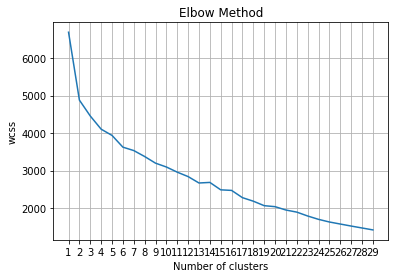

In [209]:
# Are 5 clusters really optimal?  
# Checking with the Elbow Method, 
# choosing the cluster size for which an incremented cluster size doesn't provide significant benefit.


# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

#Elbow method
wcss = [] # minimizing within cluster sum of square (WCSS)
nofc = 30
for i in range(1,nofc):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=5, random_state=0)
    km.fit(venues1K_grouped_clustering)
    wcss.append(km.inertia_)


plt.plot(range(1,nofc),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.xticks(range(1,nofc))
plt.grid(True)
plt.show()

In [ ]:
# For this dataset, 6 appears to be the optimal cluster size

In [210]:
kclusters = 6
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues1K_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [222]:
# Redo with 6 clusters

neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()

Cluster Labels                                       Neighborhood  \
0               4                           Adelaide, King, Richmond   
1               0                                          Agincourt   
2               0  Agincourt North, L'Amoreaux East, Milliken, St...   
3               0  Albion Gardens, Beaumond Heights, Humbergate, ...   
4               0                             Alderwood, Long Branch   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                  Café           Coffee Shop                 Hotel   
1    Chinese Restaurant         Shopping Mall           Coffee Shop   
2    Chinese Restaurant           Pizza Place              Pharmacy   
3           Pizza Place         Grocery Store              Pharmacy   
4        Discount Store           Pizza Place              Pharmacy   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0               Theater   American Restaurant   Japanese Restaurant   
1                Bakery            Restaurant        Sandwich Place   
2                Bakery             BBQ Joint                  Park   
3      Sushi Restaurant  Fast Food Restaurant                  Park   
4         Grocery Store         Garden Center        Sandwich Place   

  7th Most Common Venue 8th Most Common Venue  9th Most Common Venue  \
0          Concert Hall         Movie Theater        Thai Restaurant   
1           Supermarket  Caribbean Restaurant  Vietnamese Restaurant   
2          Dessert Shop           Event Space       Malay Restaurant   
3            Beer Store   Fried Chicken Joint         Hardware Store   
4            Donut Shop          Liquor Store            Gas Station   

  10th Most Common Venue  
0                 Bakery  
1        Badminton Court  
2          Shopping Mall  
3            Coffee Shop  
4          Shopping Mall

In [211]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
venues1K_merged = venues1K
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
venues1K_merged = venues1K_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
venues1K_merged.head() # check the last columns!

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Rouge, Malvern              43.806686              -79.194353   
1  Rouge, Malvern              43.806686              -79.194353   
2  Rouge, Malvern              43.806686              -79.194353   
3  Rouge, Malvern              43.806686              -79.194353   
4  Rouge, Malvern              43.806686              -79.194353   

                 Venue  Venue Latitude  Venue Longitude  \
0   Images Salon & Spa       43.802283       -79.198565   
1       Caribbean Wave       43.798558       -79.195777   
2  Staples Morningside       43.800285       -79.196607   
3              Wendy's       43.802008       -79.198080   
4             Harvey's       43.800106       -79.198258   

                  Venue Category  Cluster Labels 1st Most Common Venue  \
0                            Spa               3  Fast Food Restaurant   
1           Caribbean Restaurant               3  Fast Food Restaurant   
2  Paper / Office Supplies Store               3  Fast Food Restaurant   
3           Fast Food Restaurant               3  Fast Food Restaurant   
4           Fast Food Restaurant               3  Fast Food Restaurant   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Coffee Shop        Sandwich Place                   Gym   
1           Coffee Shop        Sandwich Place                   Gym   
2           Coffee Shop        Sandwich Place                   Gym   
3           Coffee Shop        Sandwich Place                   Gym   
4           Coffee Shop        Sandwich Place                   Gym   

  5th Most Common Venue    6th Most Common Venue 7th Most Common Venue  \
0                Bakery  Fruit & Vegetable Store    Chinese Restaurant   
1                Bakery  Fruit & Vegetable Store    Chinese Restaurant   
2                Bakery  Fruit & Vegetable Store    Chinese Restaurant   
3                Bakery  Fruit & Vegetable Store    Chinese Restaurant   
4                Bakery  Fruit & Vegetable Store    Chinese Restaurant   

           8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0  Paper / Office Supplies Store                  Park       Greek Restaurant  
1  Paper / Office Supplies Store                  Park       Greek Restaurant  
2  Paper / Office Supplies Store                  Park       Greek Restaurant  
3  Paper / Office Supplies Store                  Park       Greek Restaurant  
4  Paper / Office Supplies Store                  Park       Greek Restaurant

In [223]:
# Create a visual of the clustered neighborhoods

clusters6Map = folium.Map(location=[latitude, longitude], zoom_start=11)
colors = ['blue','green','pink','yellow','orange', 'purple']  
names = [0,1,2,3,4,5]
for Latitude, Longitude, Hood, clusterNum in zip(venues1K_forPlotting['Neighborhood Latitude'], venues1K_forPlotting['Neighborhood Longitude'], venues1K_forPlotting['Neighborhood'], venues1K_forPlotting['Cluster Labels']):
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=14,
        color=None,
        fill=True,
        fill_color=colors[clusterNum],
        fill_opacity=0.5,
        parse_html=False).add_to(clusters6Map)
clusters6Map.save('clusters6Map.html')
clusters6Map

In [225]:
# Add locations of marijuana dispensaries to neighborhood clusters

for i in range(0, len(toro_marijuana)-1):
# for row in toro_marijuana:
    folium.CircleMarker(
        [toro_marijuana.iloc[i]['Latitude'], toro_marijuana.iloc[i]['Longitude']],
        radius=4,
        popup='PotShop',
        color='crimson',
        fill=True,
        fill_color='pink',
        fill_opacity=0.5).add_to(clusters6Map)
clusters6Map.save('clusters6MapWdispensaries.html')
clusters6Map

In [ ]:
# Choosing six cluster showed an improvement the the ability to discern marijuana locations

<H4><center>Which are the best and worst areas to locate a marijuana dispensary, based on neighborhood characteristics?</H4>

In [242]:
# Find Best/Worst Clusters
clusters_ranked = pd.DataFrame(kmeans.cluster_centers_)
clusters_ranked.columns = venues1K_onehot.columns
clusters_ranked.index = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']  
clusters_ranked['TotalSum'] = cluster_centroids.sum(axis=1)
# clusters_ranked.sort_values(axis=0, by=['TotalSum'], ascending=False)
(clusters_ranked.TotalSum).sort_values(axis=0, ascending=False)

C5    200.800000
C3    200.000000
C4    199.666667
C6    197.428571
C2    144.750000
C1     54.827586
Name: TotalSum, dtype: float64

In [ ]:
venues_nearby.groupby('Major Category',sort=True)

In [246]:
# Create a visual of the ranked clustered neighborhoods

clusters6RankedMap = folium.Map(location=[latitude, longitude], zoom_start=11)
colors = ['lightBlue','red','lightpink','lightGreen','lightBlue', 'lightgreen']  
names = [0,1,2,3,4,5]
for Latitude, Longitude, Hood, clusterNum in zip(venues1K_forPlotting['Neighborhood Latitude'], venues1K_forPlotting['Neighborhood Longitude'], venues1K_forPlotting['Neighborhood'], venues1K_forPlotting['Cluster Labels']):
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=14,
        color=None,
        fill=True,
        fill_color=colors[clusterNum],
        fill_opacity=0.5,
        parse_html=False).add_to(clusters6RankedMap)
clusters6RankedMap.save('clusters6Map.html')
clusters6RankedMap

In [249]:
# Add locations of marijuana dispensaries to neighborhood clusters

for i in range(0, len(toro_marijuana)-1):
# for row in toro_marijuana:
    folium.CircleMarker(
        [toro_marijuana.iloc[i]['Latitude'], toro_marijuana.iloc[i]['Longitude']],
        radius=4,
        popup='PotShop',
        color='green',
        fill=True,
        fill_color='pink',
        fill_opacity=0.5).add_to(clusters6RankedMap)
clusters6RankedMap.save('clusters6RankedMap.html')
clusters6RankedMap

In [279]:
for i in range(0, len(toro_stripClubs)-1):
# for row in toro_stripClubs:
    folium.CircleMarker(
        [toro_stripClubs.iloc[i]['Latitude'], toro_stripClubs.iloc[i]['Longitude']],
        radius=4,
        popup='stripClub',
        color='blue',
        fill=True,
        fill_color='lightBlue',
        fill_opacity=0.8).add_to(clusters6RankedMap)
clusters6RankedMap.save('clusters6rankedAndStripClubs.html')
clusters6RankedMap

<H4><center>Suggestion: Locate the next marijuana dispensary near three strip clubs (and no nearby marijuana dispensaries) in the neighborhood positively ranked by Foursquare near High Park and close the University of Toronto